# Задание:

Клиенты приходят во время промо акции неравномерно. В таблице имеются данные по ряду промо акций: какая доля клиентов пришла в какой день акции. При этом промо акции длились разное время.
Необходимо создать модель, которая бы строила распределение клиентов по дням для акции произвольной продолжительности.

Вход: кол-во дней (продолжительность акции).

Выход: таблица День - Доля клиентов.

При наличии трудностей в реализации модели с входной переменной можно просто расчитать все распределения для акций продолжительностью от 1 до 50 дней.

# Решение:

Импортируем необходимые модули

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from functions import make_stocks_dict, plot_frequencies, plot_stocks, calibrate_percents, transform_stocks, \
plot_stocks_transformed, make_weights_list, linear_approximation, predict_stock, plot_predictions

%matplotlib inline

Исходный файл формата **.xlsx** был преобразован в формат **.csv** с помощью онлайн конвертера. Загрузим этот файл в таблицу **df**, посмотрим на ее начало и конец, а также на тип данных в каждой колонке.

In [2]:
df = pd.read_csv('stocks.csv', sep=',', names=['number', 'day', 'percent'], header=0)

In [3]:
df.head()

,number,day,percent
0,1,1,0.100643
1,1,2,0.084238
2,1,3,0.067400
3,1,4,0.053952
4,1,5,0.064888


In [4]:
df.tail()

,number,day,percent
642,34,10,0.063771
643,34,11,0.073510
644,34,12,0.075377
645,34,13,0.103212
646,34,14,0.129454


In [5]:
df.dtypes

number       int64
day          int64
percent    float64
dtype: object

Для удобства дальнейшей работы преобразуем таблицу **df** в словарь **stocks** вида: 

$\{... k:[..., \ (i,p_i), \ ...] ...\}$, 

где 

* $k$ - ключ, равный номеру акции, 

* [...] - значение ключа, представляющее собой список из кортежей вида $(i,p_i)$, где $i$ - номер дня в акции и $p_i$ - процент клиентов, принявших участие в акции в $i$-й день

In [6]:
stocks = make_stocks_dict(df)

Посмотрим на то, сколько длятся акции. Для этого построим зависимость количества акций от их длительности:

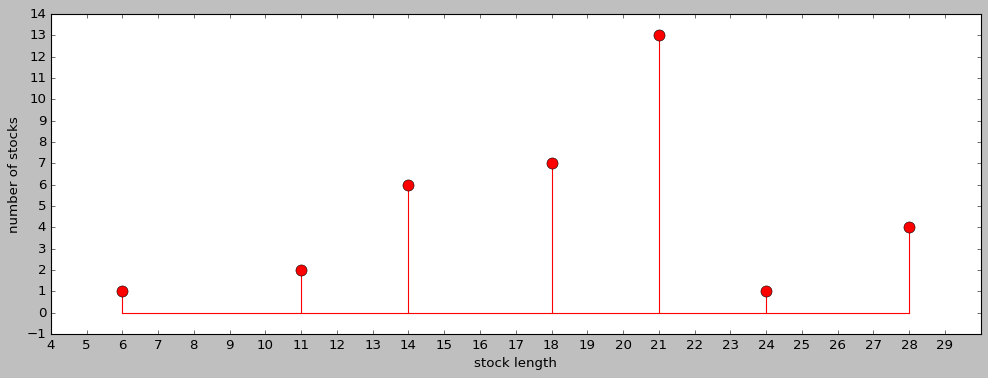

In [8]:
plot_frequencies(stocks)

Видим, что большинство акций длится от 2х до 3х недель. Теперь посмотрим на каждую акцию, построив зависимость процента пришедших клиентов от дня акции: 

checking sum of percents: 1.0


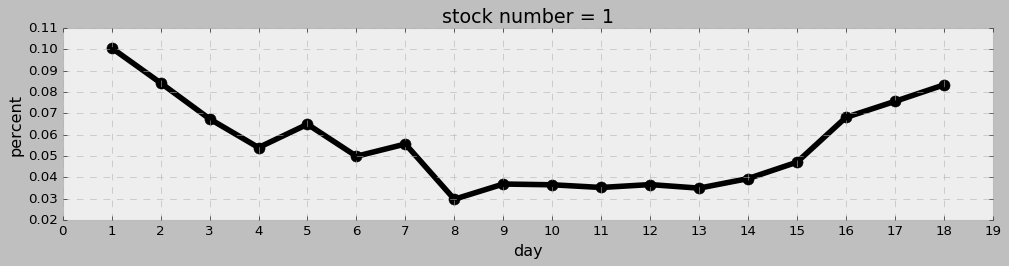

checking sum of percents: 1.0


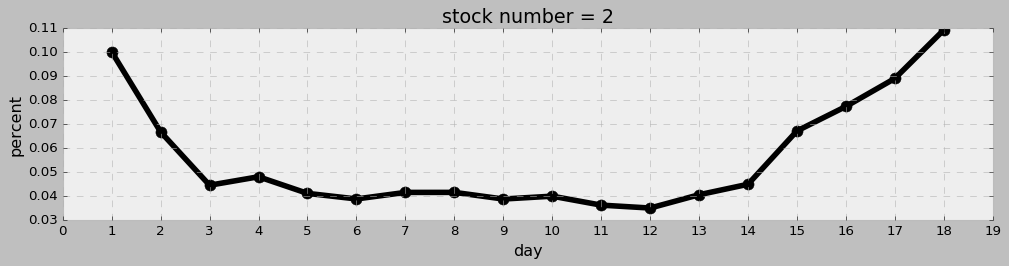

checking sum of percents: 1.0


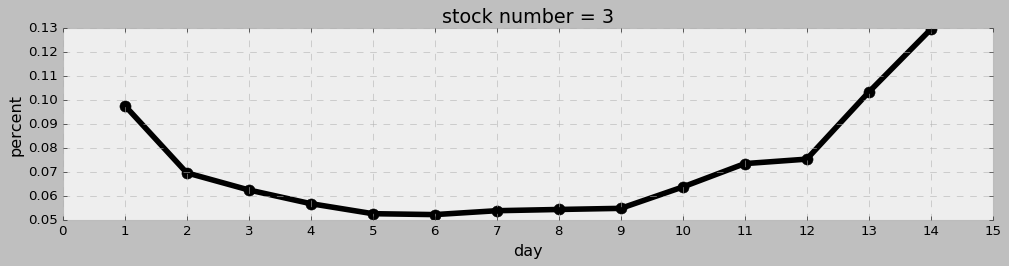

checking sum of percents: 1.0


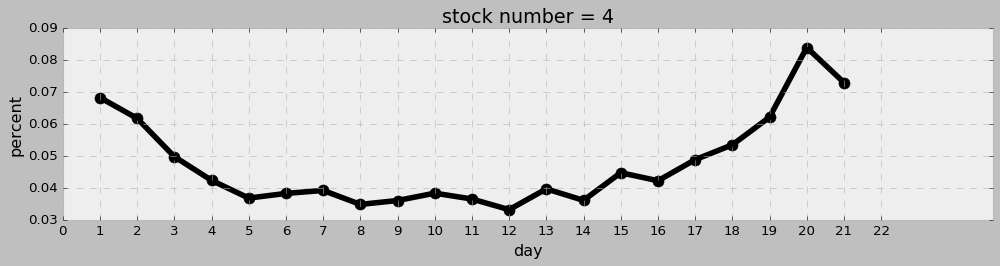

checking sum of percents: 1.0


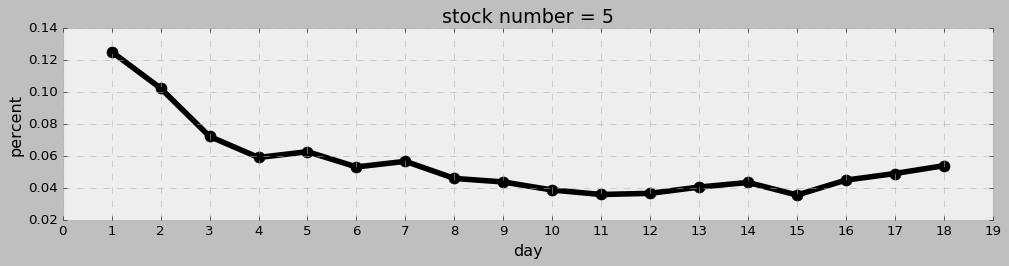

checking sum of percents: 1.0


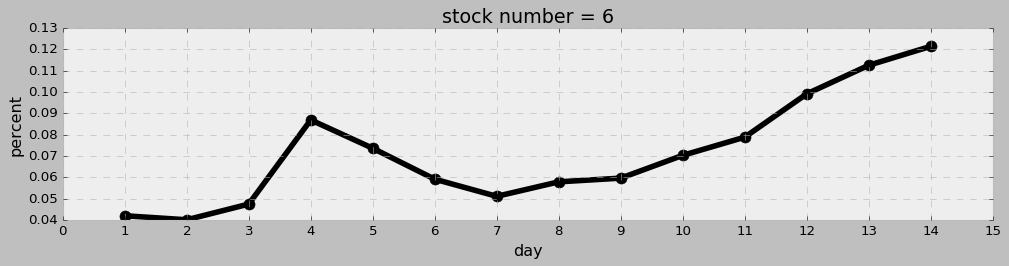

checking sum of percents: 1.0


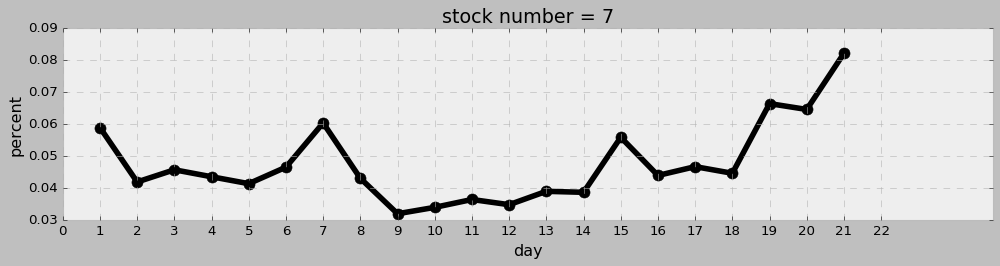

checking sum of percents: 1.0


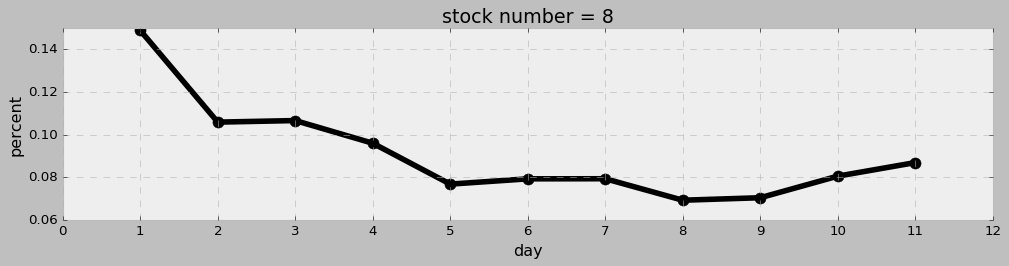

checking sum of percents: 1.0


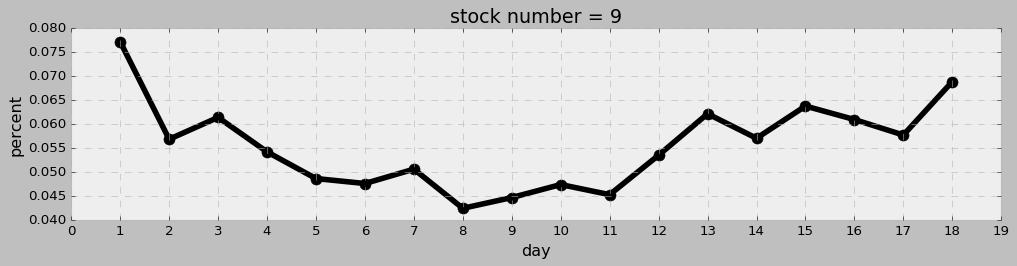

checking sum of percents: 1.0


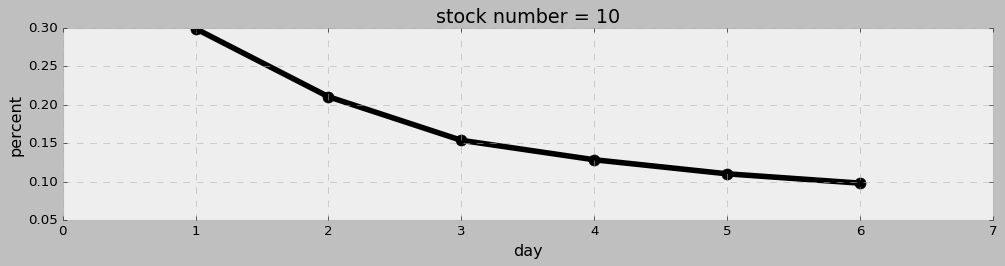

checking sum of percents: 1.0


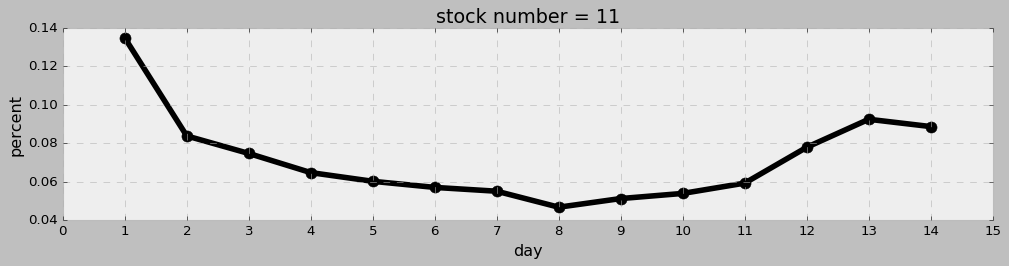

checking sum of percents: 1.0


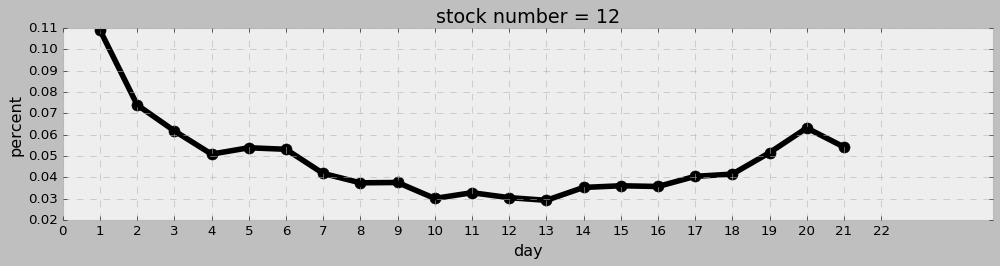

checking sum of percents: 1.0


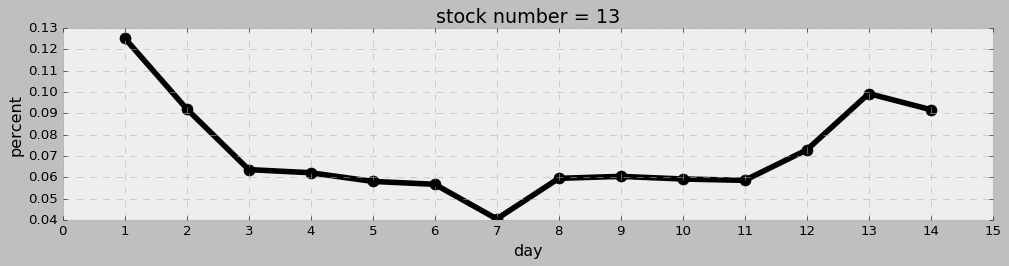

checking sum of percents: 1.0


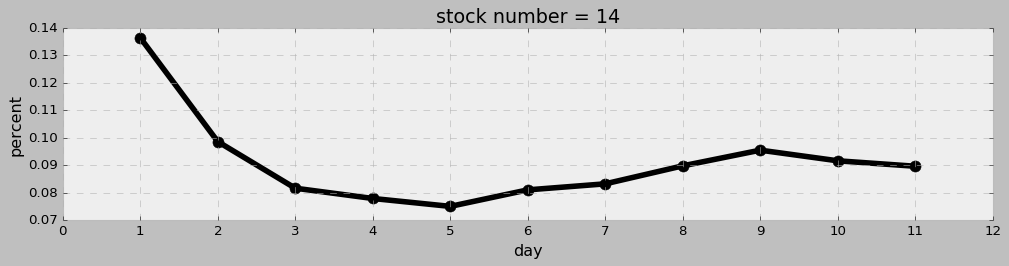

checking sum of percents: 1.0


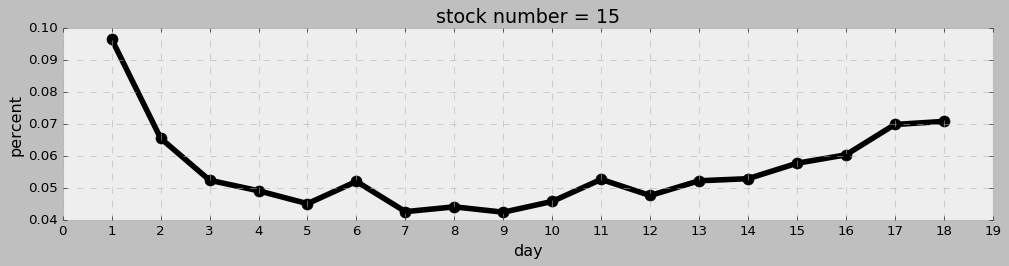

checking sum of percents: 1.0


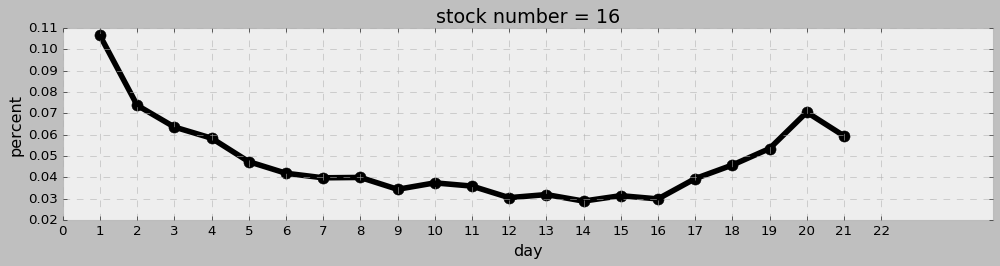

checking sum of percents: 1.0


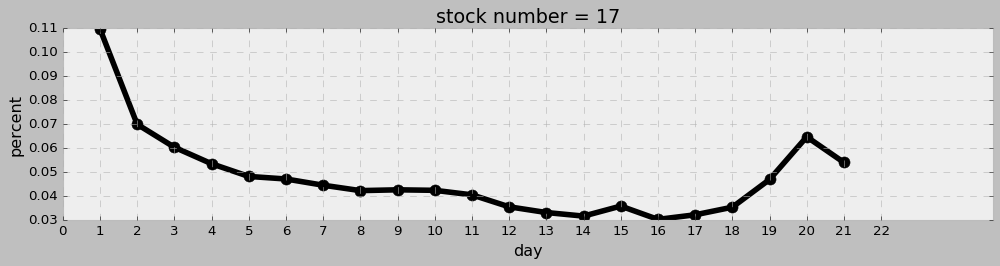

checking sum of percents: 1.0


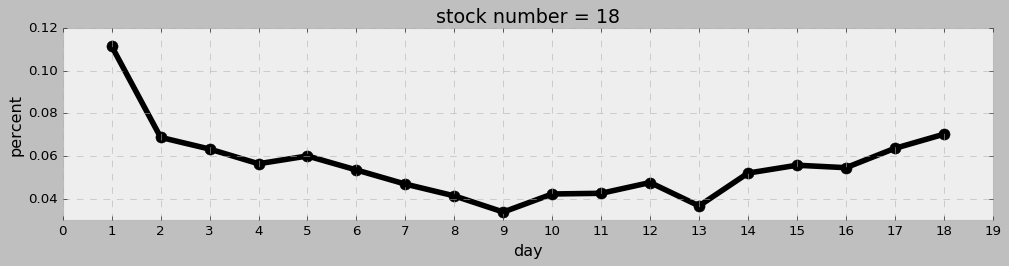

checking sum of percents: 1.0


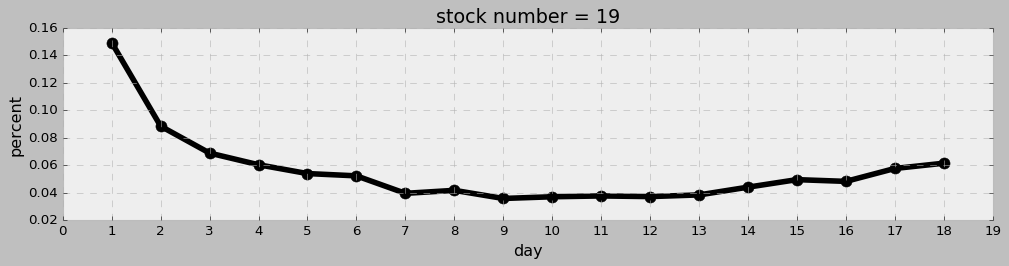

checking sum of percents: 1.0


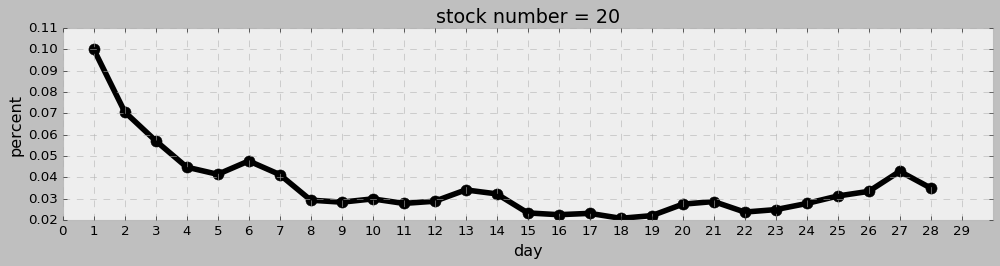

checking sum of percents: 1.0


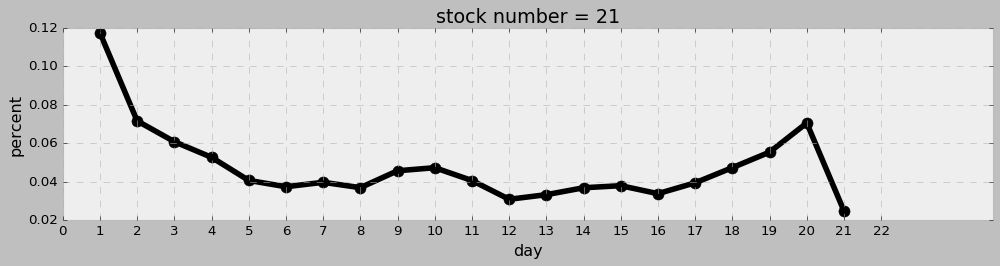

checking sum of percents: 1.0


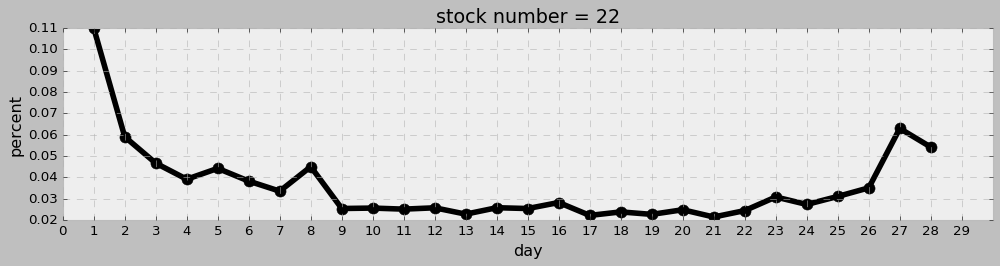

checking sum of percents: 1.0


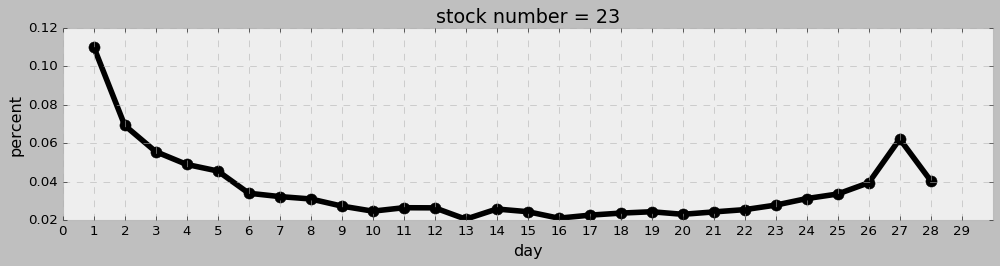

checking sum of percents: 1.0


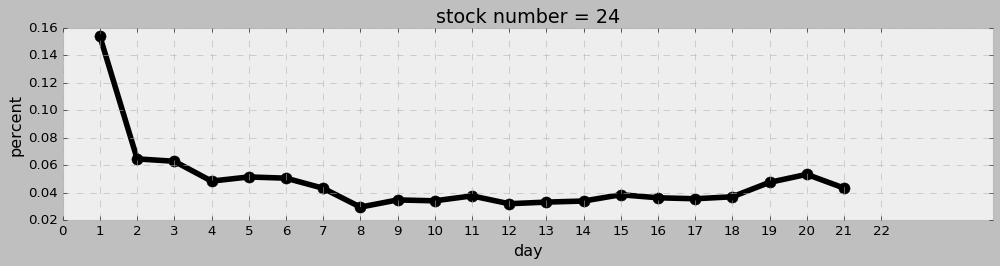

checking sum of percents: 1.0


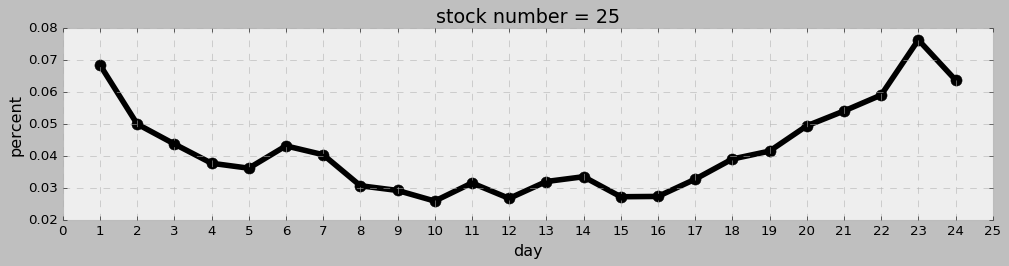

checking sum of percents: 1.0


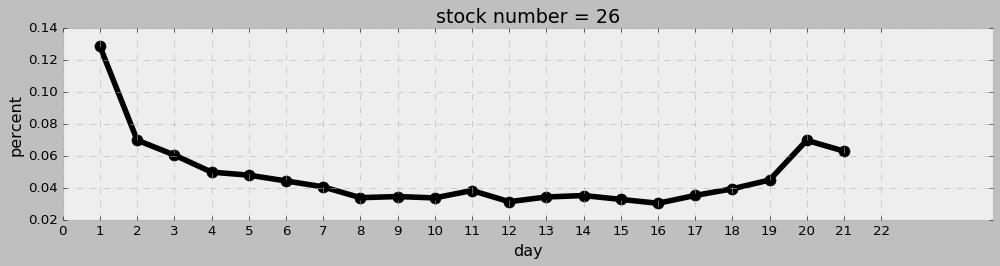

checking sum of percents: 1.0


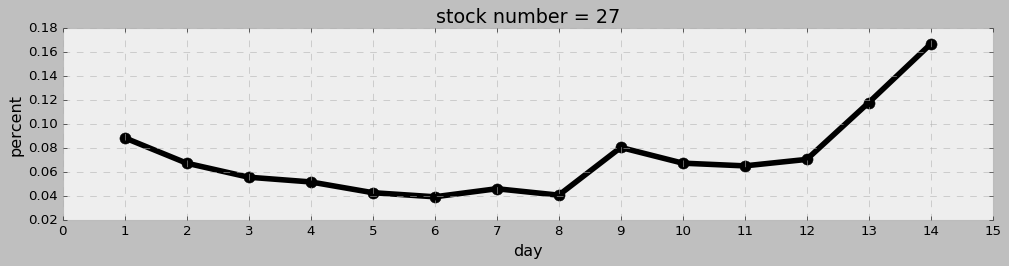

checking sum of percents: 1.0


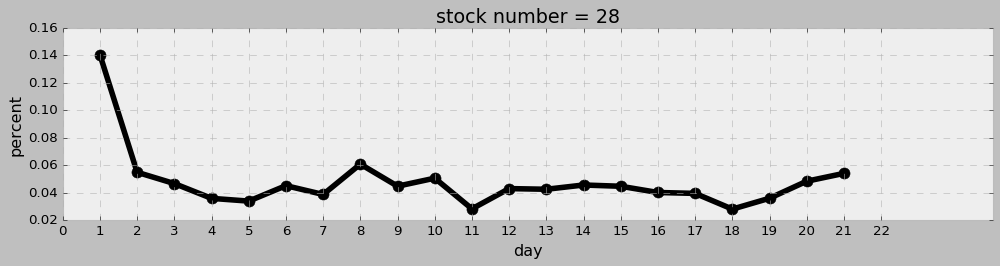

checking sum of percents: 1.0


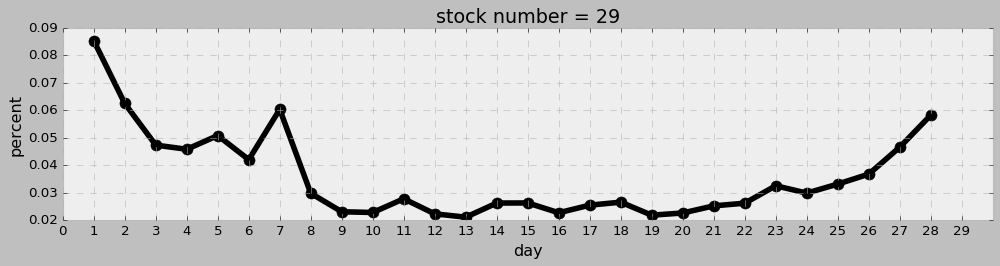

checking sum of percents: 1.0


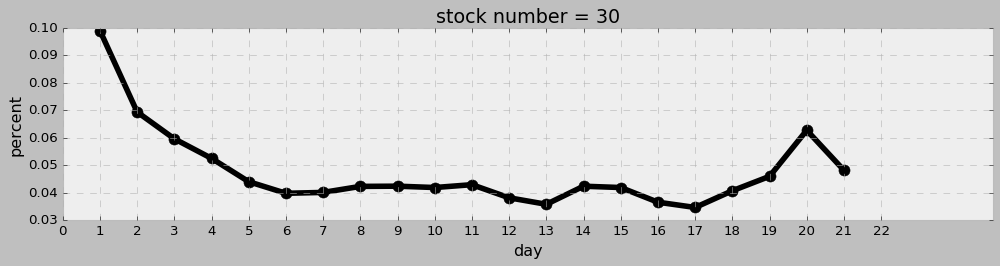

checking sum of percents: 1.0


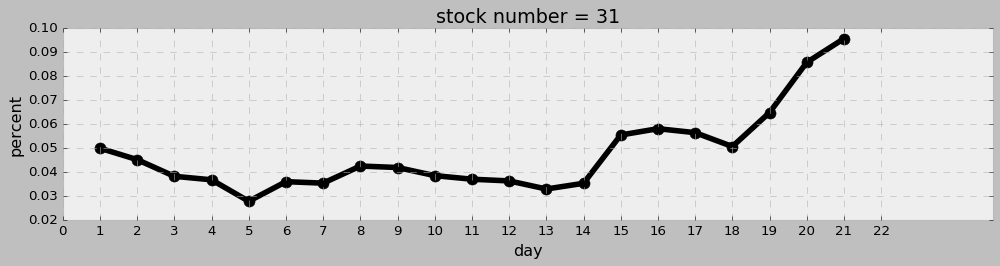

checking sum of percents: 1.0


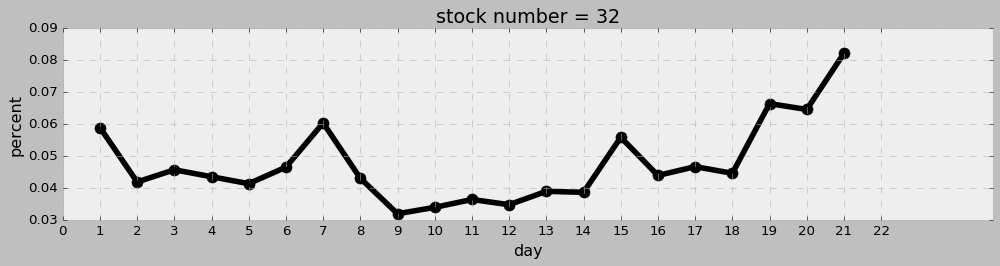

checking sum of percents: 1.0


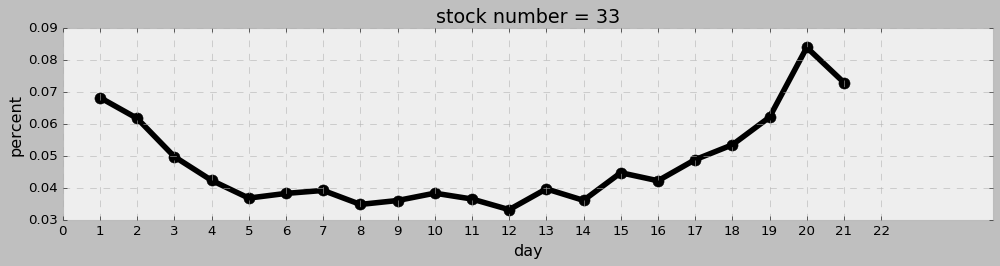

checking sum of percents: 1.0


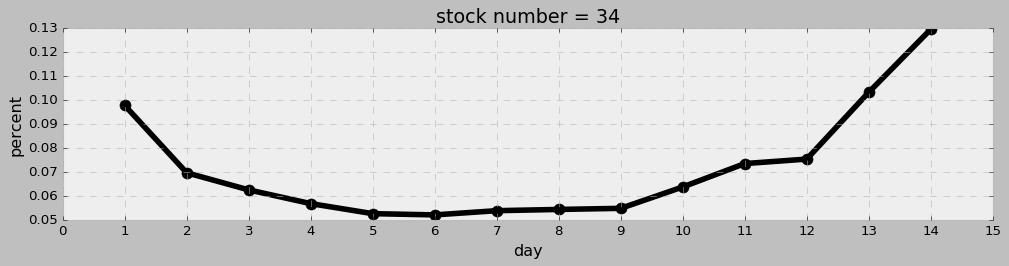

In [10]:
plot_stocks(stocks)

Сумма процентов посещаемости за все дни акции должна быть равна 100%, и перед построением графиков происходит проверка этого условия. Таким образом, лишний раз данные анализируются на предмет корректности.

Заметим, что в среднем пик посещаемости клиентов приходится на начало и конец акций.

Перейдем непосредственно к решению задачи. Основная сложность в условии заключается в том, что дана статистика только по 7 разным продолжительностям акций, в то время как требуется предсказать посещаемость для произвольной длительности акций. 

Думаю, что логичным будет предположить следующее: если есть заданная длительность акции *stock_length* и есть статистика по нескольким длительностям *stock_lengths = [stock_length_1, ..., stock_length_N]*, то искомая посещаемость акции длительностью *stock_length* будет больше похожа на посещаемость акций схожих длительностей и меньше похожа на посещаемость акций, сильно отличающихся по длительностям. По-другому говоря, искомая посещаемость акции заданной длительности есть взвешенная сумма посещаемостей других акций, причем веса тем больще, чем длительность акций из статистики ближе к заданной длительности.

Реализацию описанного алгоритма начнем с того, что преобразуем словарь **stocks** в **stocks_transformed**, спроецировав динамику посещаемости на отрезок [0,1] и усреднив посещаемости акций с одинаковой длительности. Такими образом, ключей в новом словаре станет не 34, а 7 (поскольку именно столько разных длительностей акций). 

Отметим, что при усреднении процентов посещаемости по нескольким акциям сумма процентов посещаемости в результирующей акции неизбежно будет отличаться от 100%. Поэтому после усреднения для каждого дня от процента посещаемости отнимается такая контанта, чтобы условие нормировки выполнялось. Назовем это калибровкой посещаемости.

In [11]:
stocks_transformed = transform_stocks(stocks)

Посмотрим на получившиеся графики:

checking sum of percents: 1.0


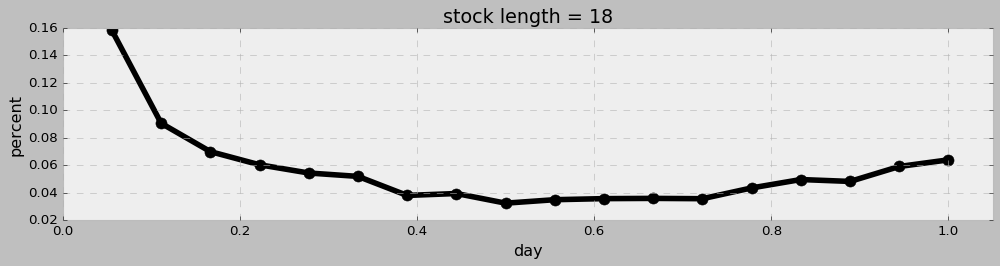

checking sum of percents: 1.0


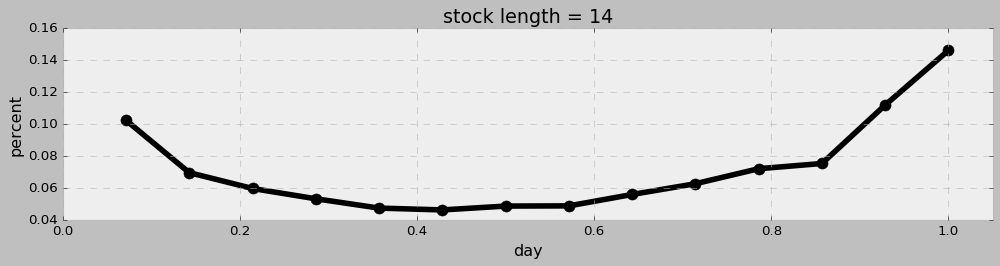

checking sum of percents: 1.0


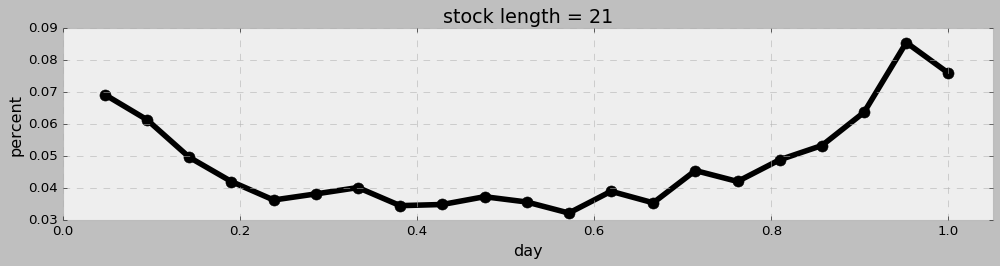

checking sum of percents: 1.0


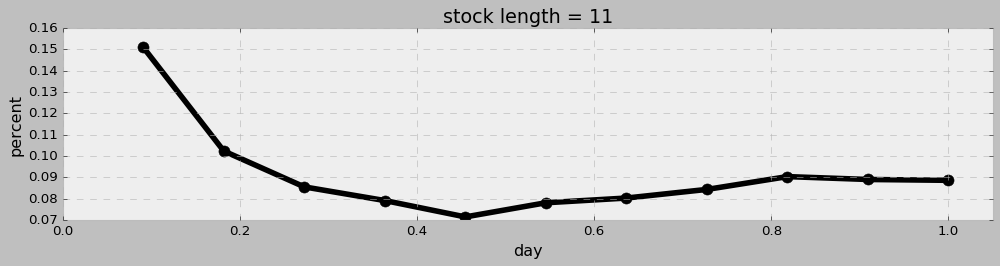

checking sum of percents: 1.0


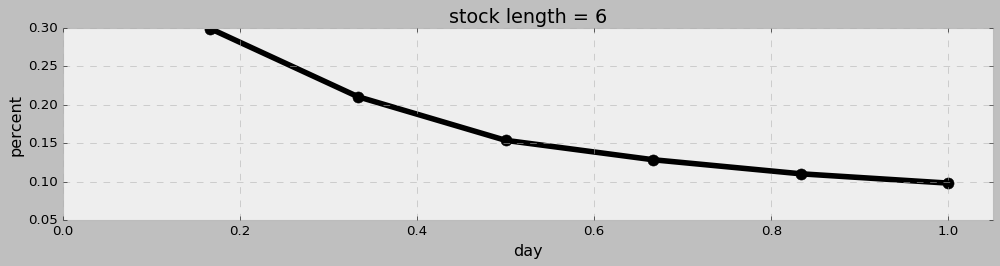

checking sum of percents: 1.0


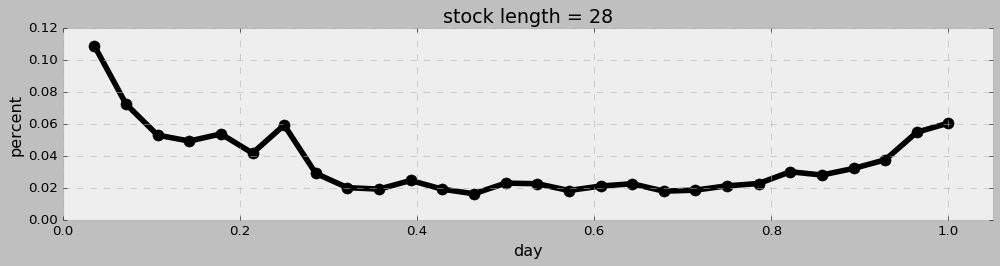

checking sum of percents: 1.0


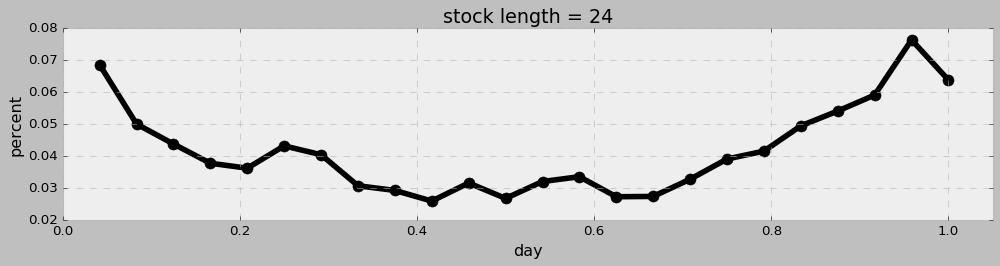

In [12]:
plot_stocks_transformed(stocks_transformed)

К вопросу реализации взвешенной суммы можно подойти по-разному. В данном случае оставлюсь на экспоненциальном (1я степень) угасании весов по мере увеличения разницы между заданной длительностью акции и длительностью акций в имеющейся статистике.

Напомню, что на данный момент все посещаемости акций спроецированы на отрезок [0,1]. То есть на этом отрезке будет 6 точек для акции, длящейся 6 дней, 15 точек для акции, длящейся 15 дней и т.п. Для расчета взвешенной суммы необходимо знать значения посещаемости в одной и той же абсциссе. Чтобы получать его, была использована линейная аппроксимация в соседних к требуемой абсциссе точках.

Поскольку в условии сказано, что необходимо написать функцию, на вход которой подается только длительность акции, то не будет передавать в функцию уже готовый словарь **stocks_transformed**, а получим его внутри.

Рассчитаем посещаемость для заданной длительности акции:

In [13]:
stock_length = 15
df_prediction = predict_stock(stock_length)

In [14]:
df_prediction.head(len(df_prediction))

,day,percent
0,1,0.128378
1,2,0.0946567
2,3,0.0771175
3,4,0.0680769
4,5,0.0592212
5,6,0.0517551
6,7,0.0488414
7,8,0.0477817
8,9,0.0481251
9,10,0.0483488


In [15]:
print('sum of percents: ', sum(df_prediction['percent']))

sum of percents:  1.0


Построим графики посещаемости акций длительностью от 1 до 50 дней:

checking sum of percents: 1.0


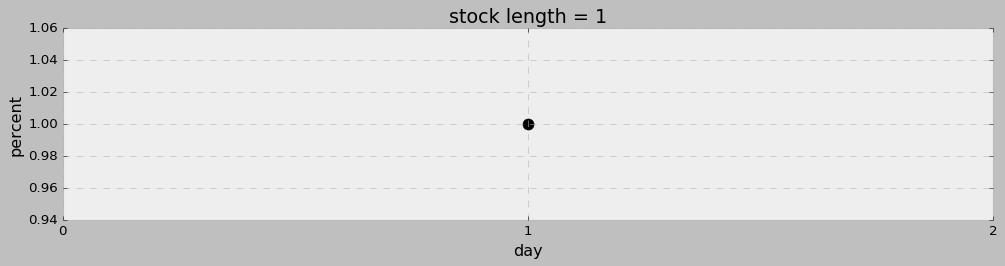

checking sum of percents: 1.0


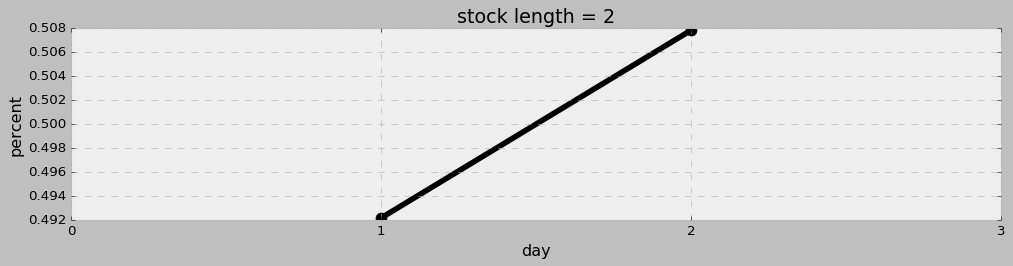

checking sum of percents: 1.0


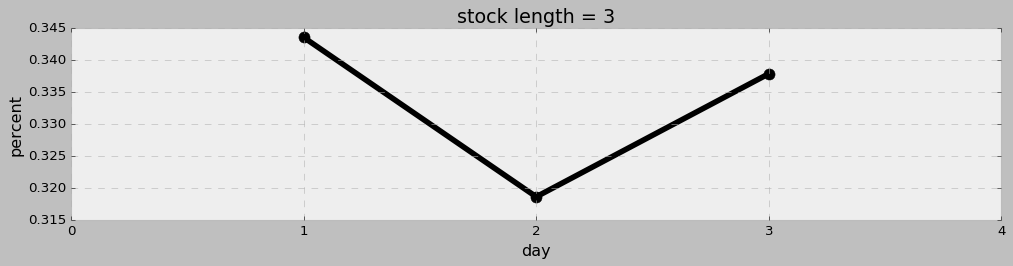

checking sum of percents: 1.0


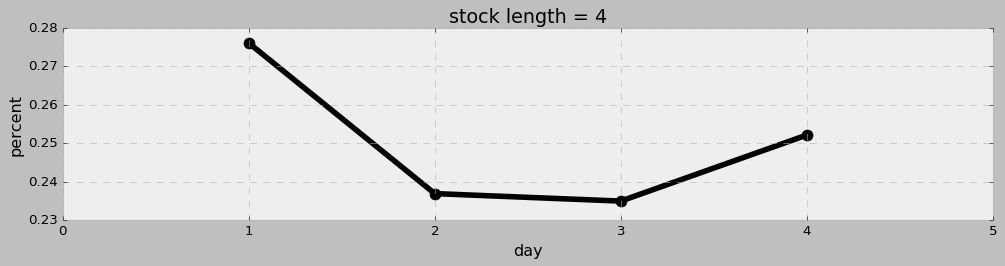

checking sum of percents: 1.0


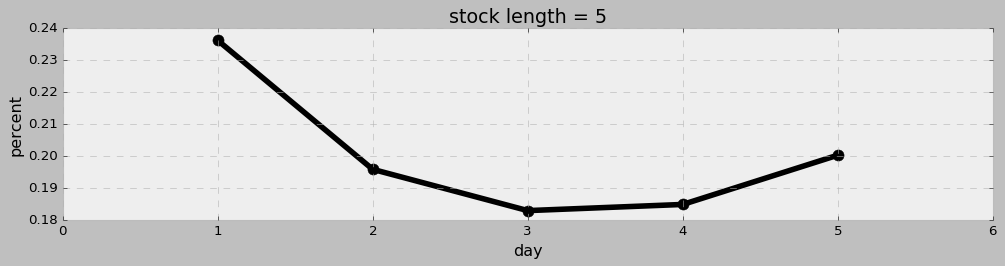

checking sum of percents: 1.0


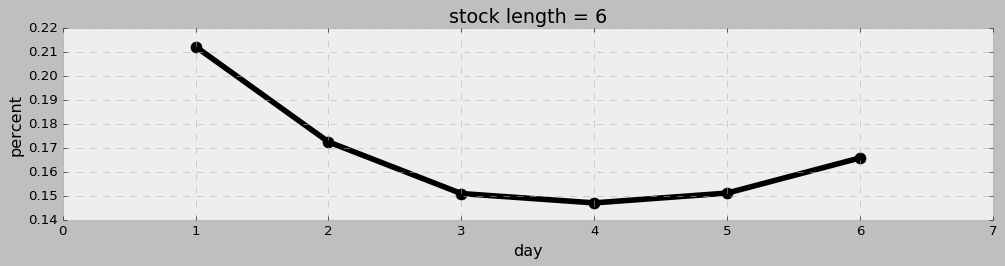

checking sum of percents: 1.0


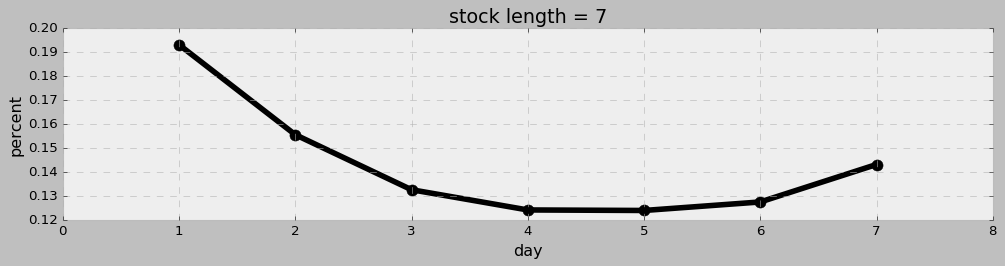

checking sum of percents: 1.0


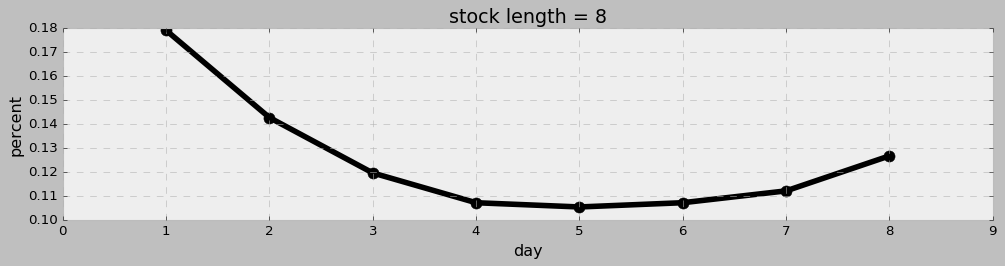

checking sum of percents: 1.0


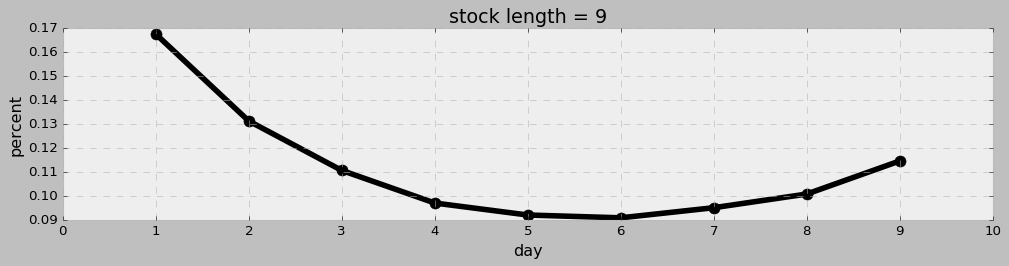

checking sum of percents: 1.0


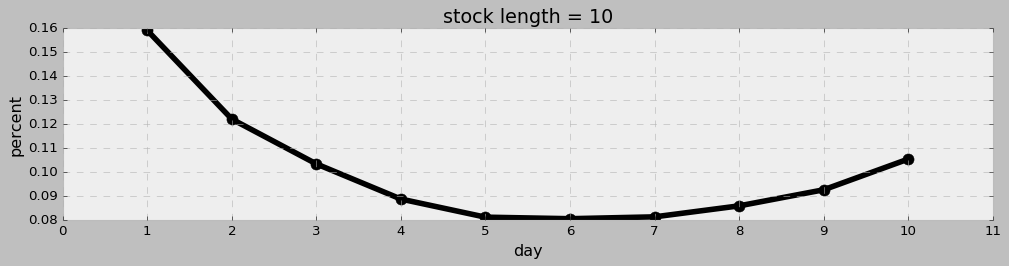

checking sum of percents: 1.0


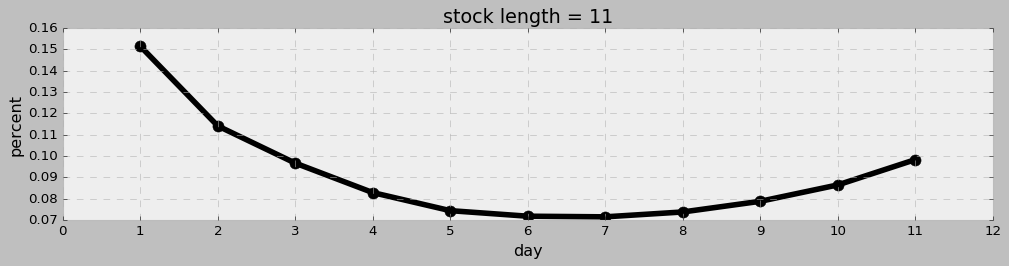

checking sum of percents: 1.0


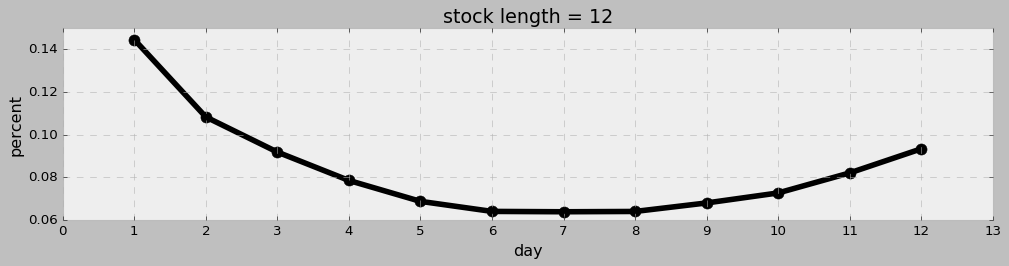

checking sum of percents: 1.0


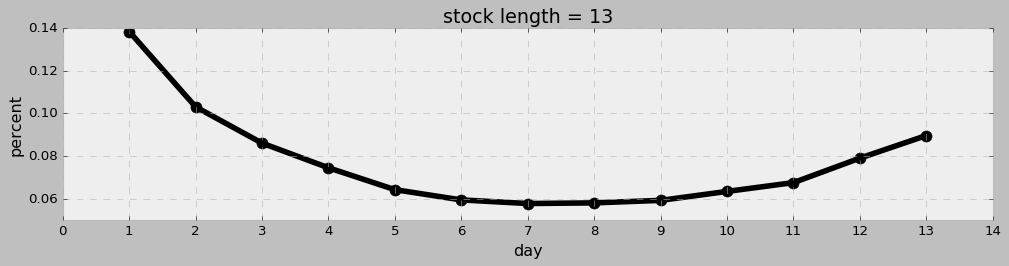

checking sum of percents: 1.0


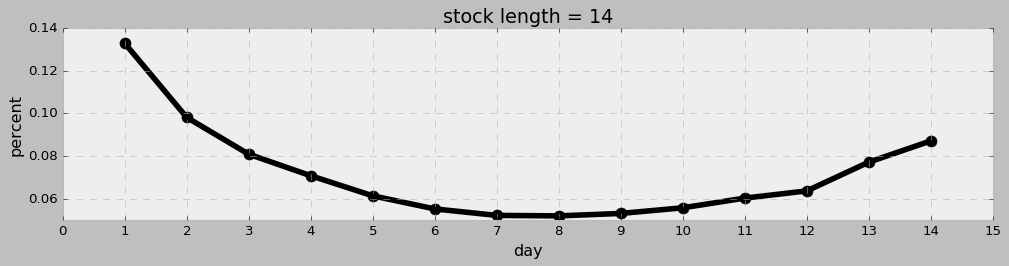

checking sum of percents: 1.0


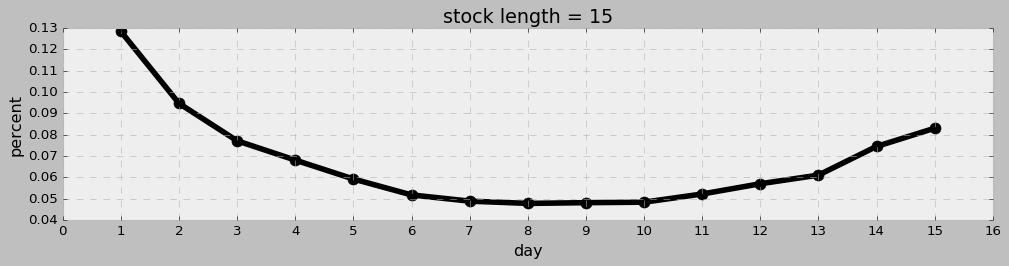

checking sum of percents: 1.0


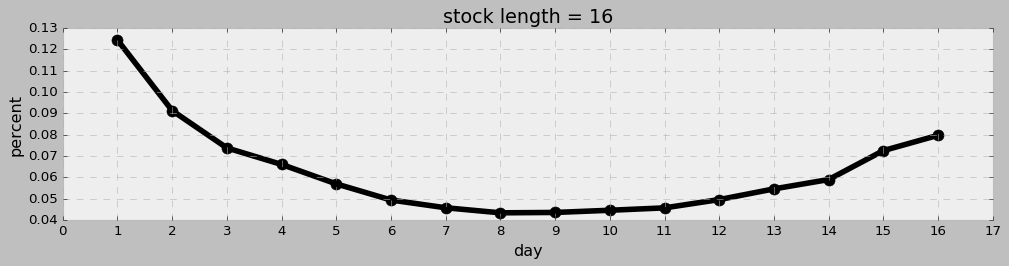

checking sum of percents: 1.0


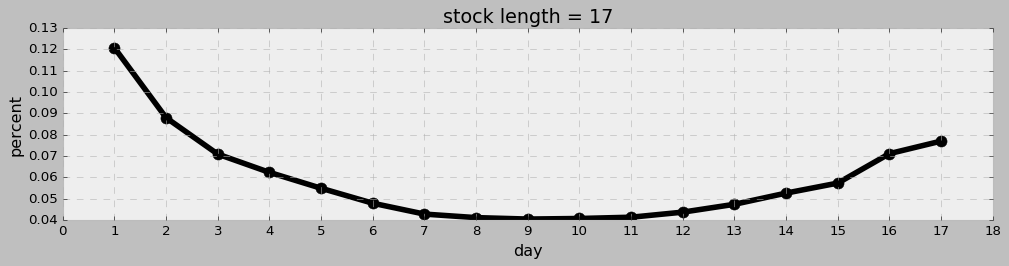

checking sum of percents: 1.0


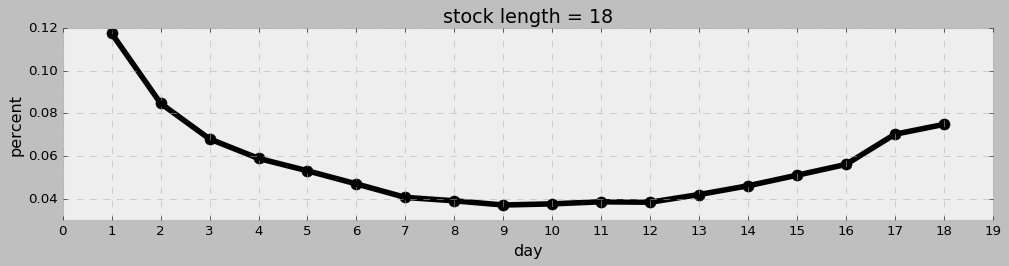

checking sum of percents: 1.0


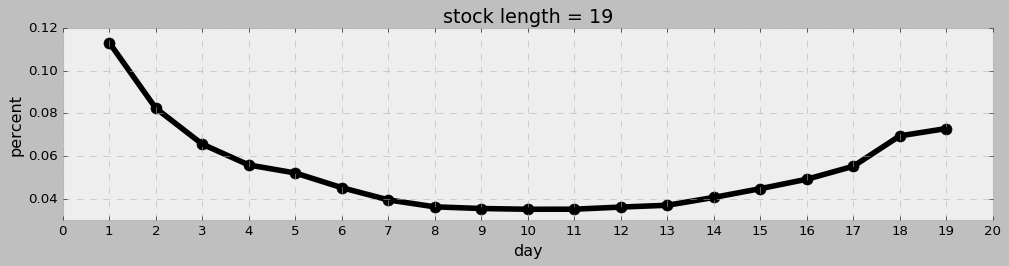

checking sum of percents: 1.0


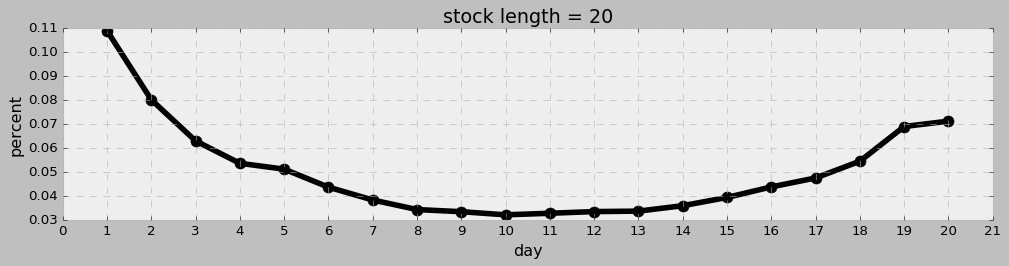

checking sum of percents: 1.0


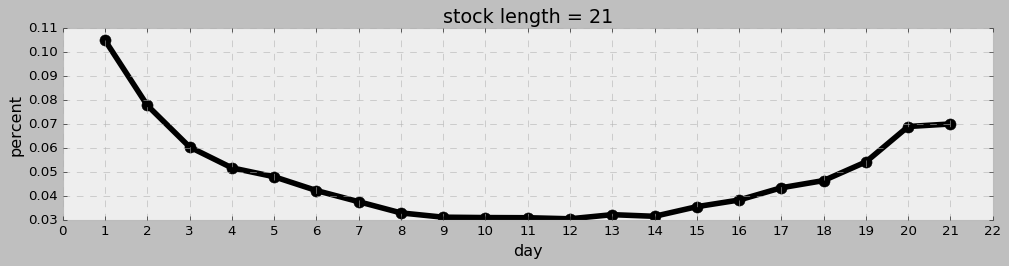

checking sum of percents: 1.0


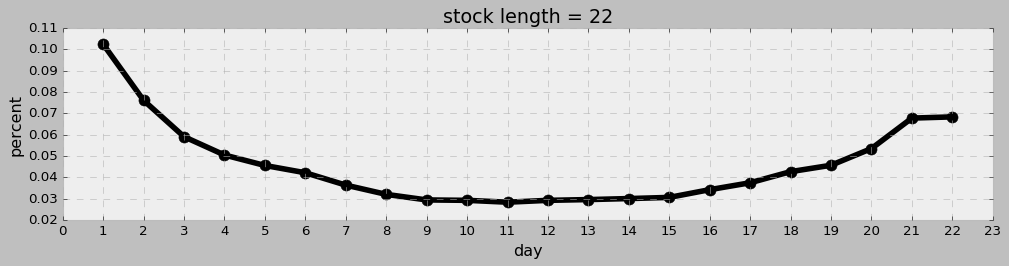

checking sum of percents: 1.0


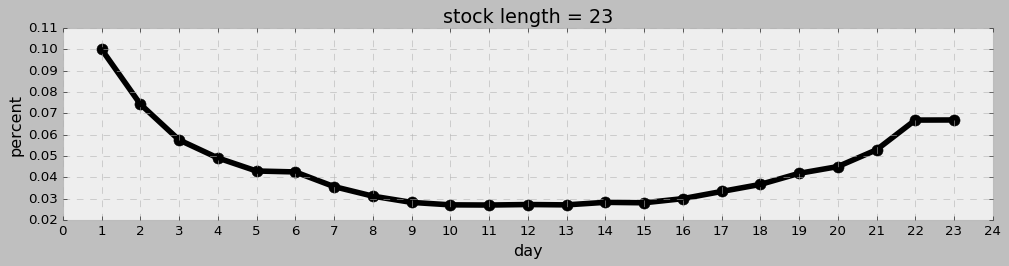

checking sum of percents: 1.0


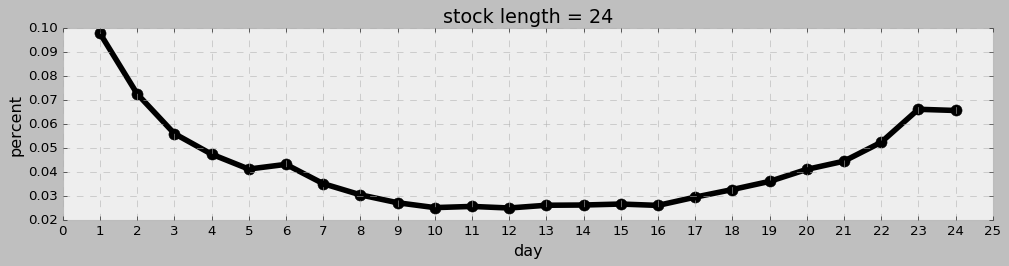

checking sum of percents: 1.0


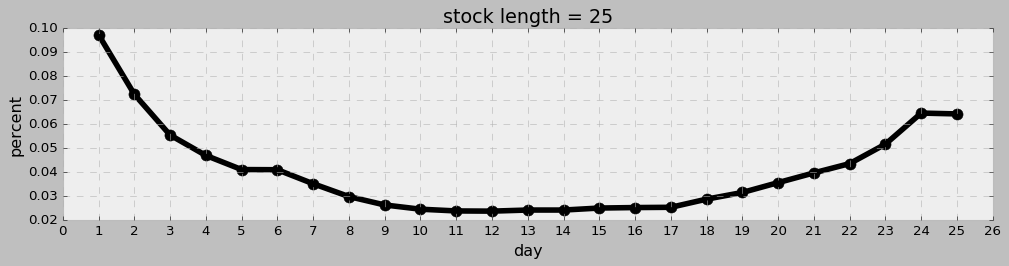

checking sum of percents: 1.0


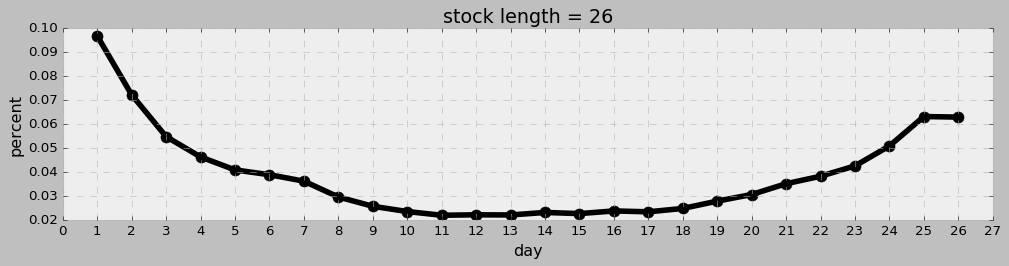

checking sum of percents: 1.0


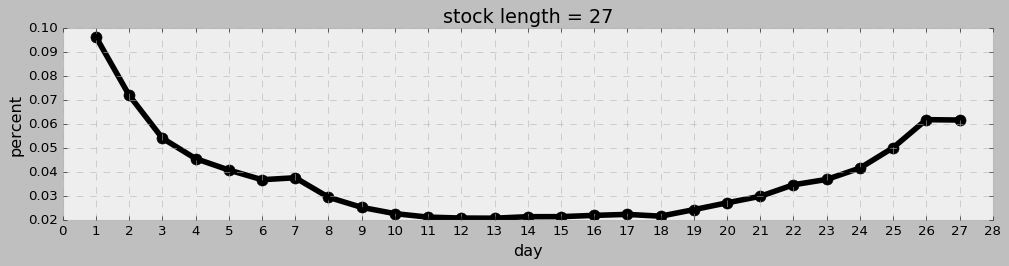

checking sum of percents: 1.0


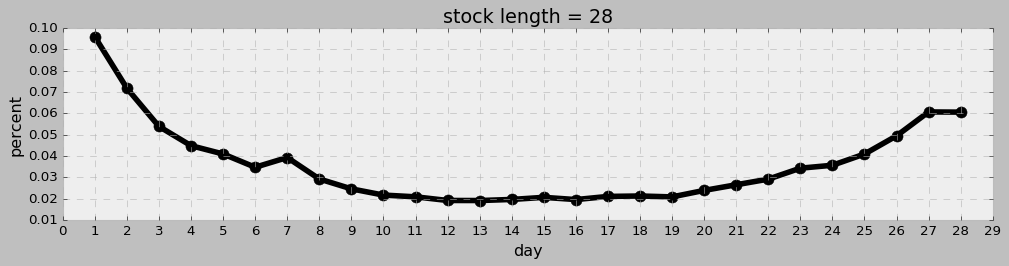

checking sum of percents: 1.0


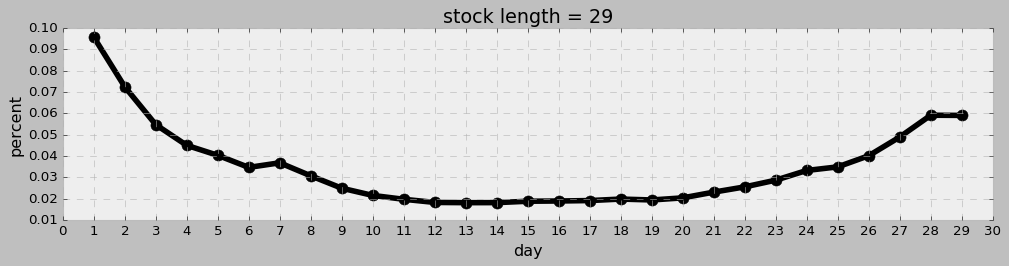

checking sum of percents: 1.0


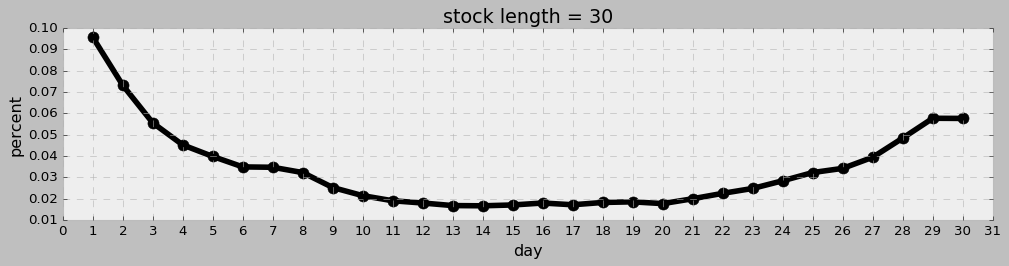

checking sum of percents: 1.0


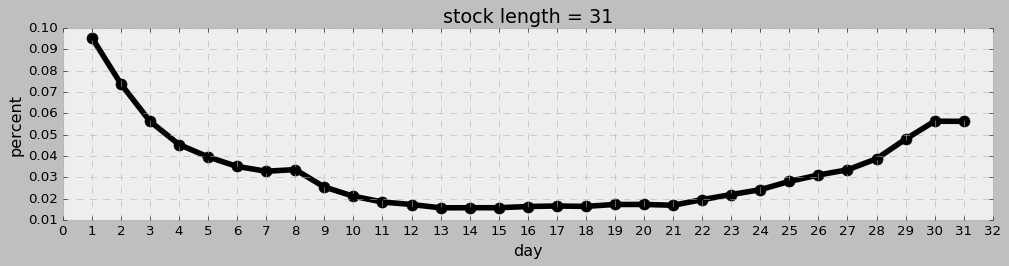

checking sum of percents: 1.0


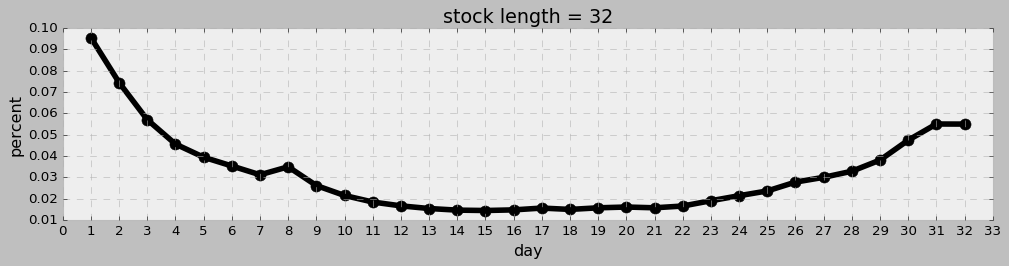

checking sum of percents: 1.0


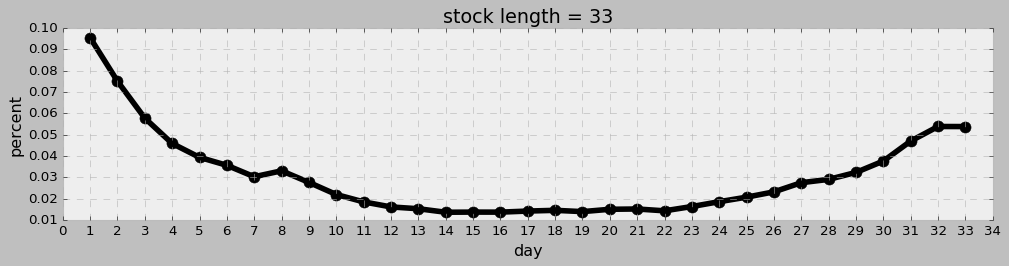

checking sum of percents: 1.0


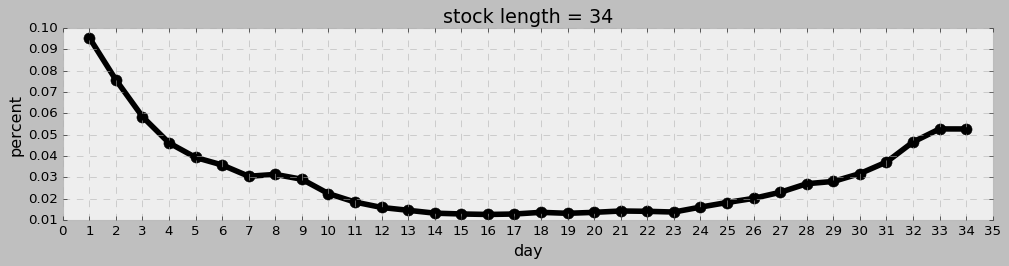

checking sum of percents: 1.0


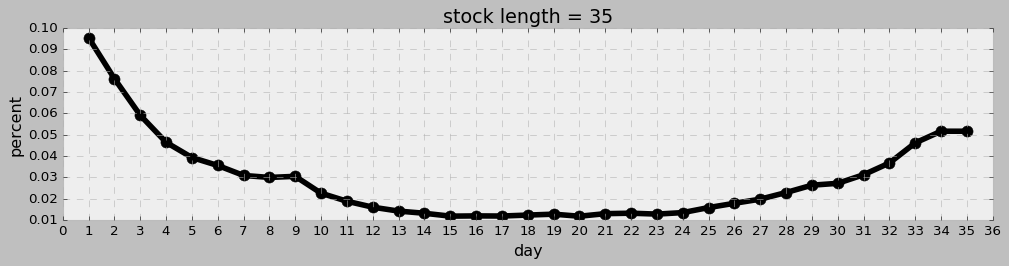

checking sum of percents: 1.0


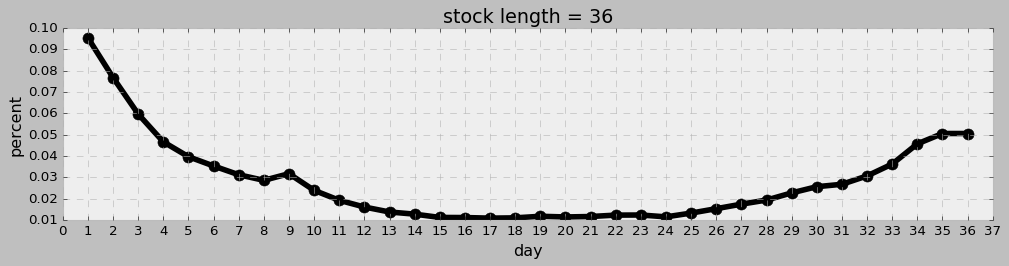

checking sum of percents: 1.0


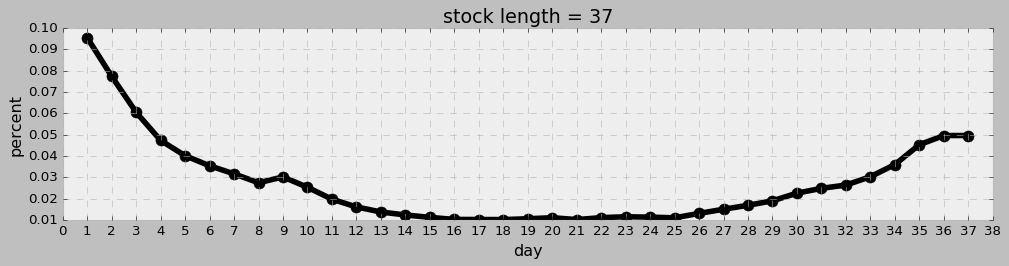

checking sum of percents: 1.0


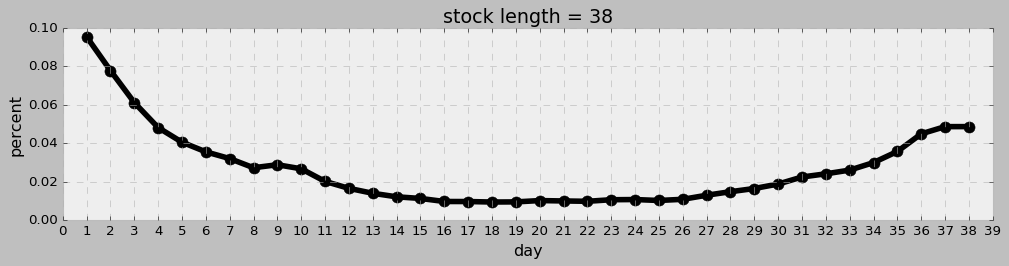

checking sum of percents: 1.0


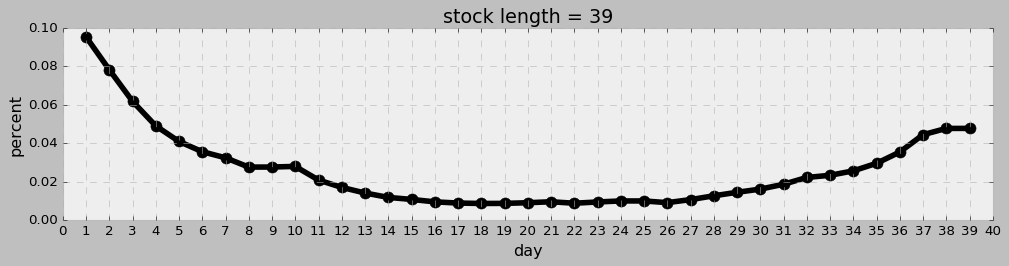

checking sum of percents: 1.0


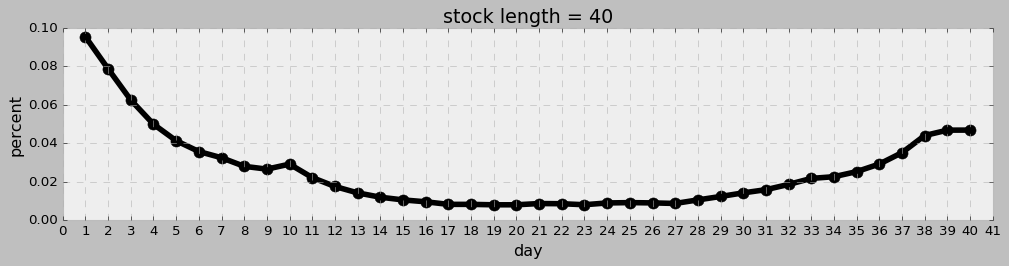

checking sum of percents: 1.0


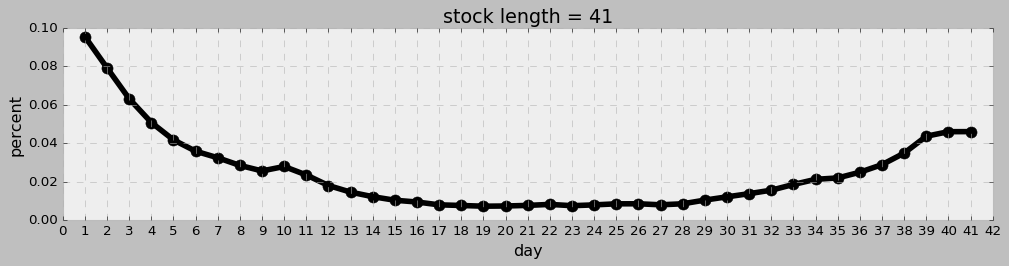

checking sum of percents: 1.0


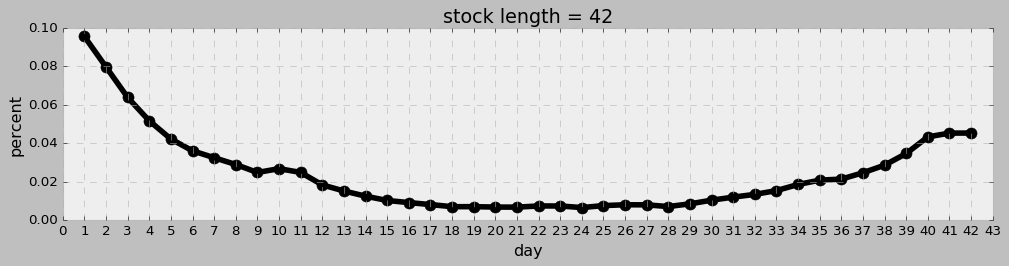

checking sum of percents: 1.0


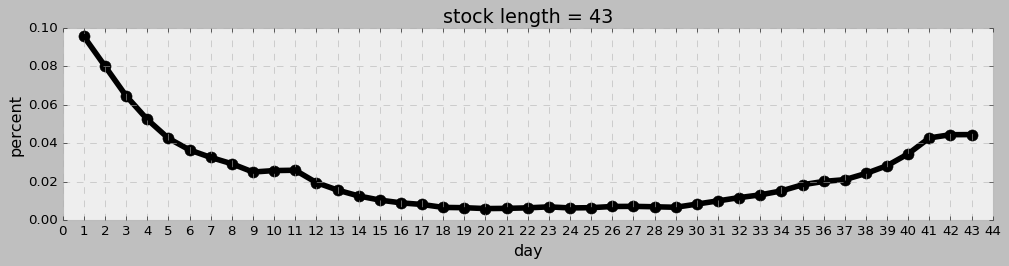

checking sum of percents: 1.0


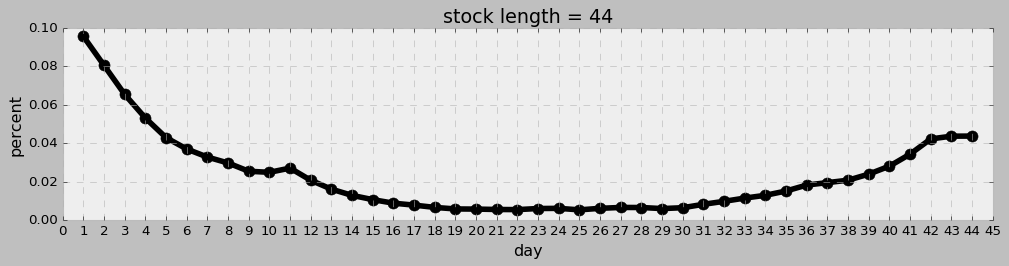

checking sum of percents: 1.0


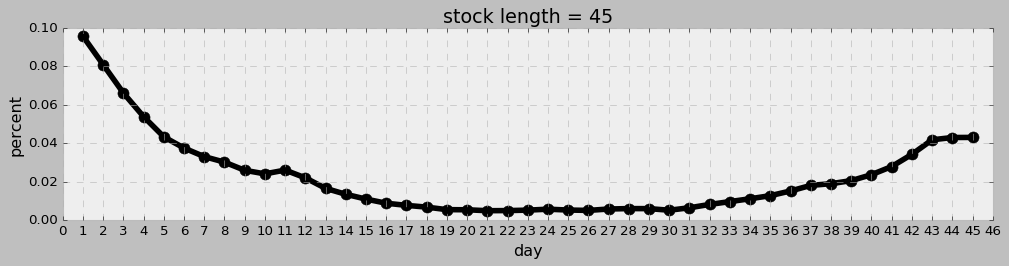

checking sum of percents: 1.0


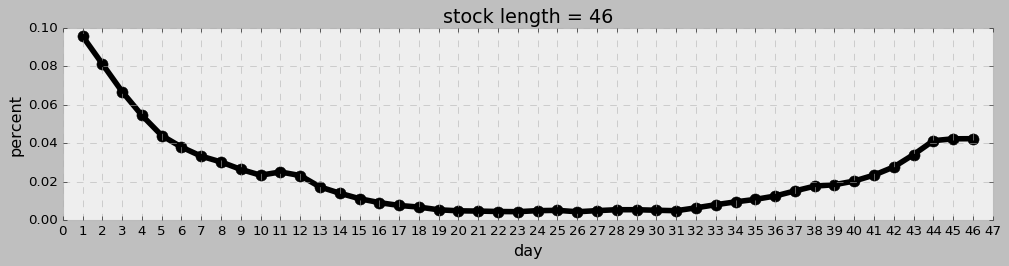

checking sum of percents: 1.0


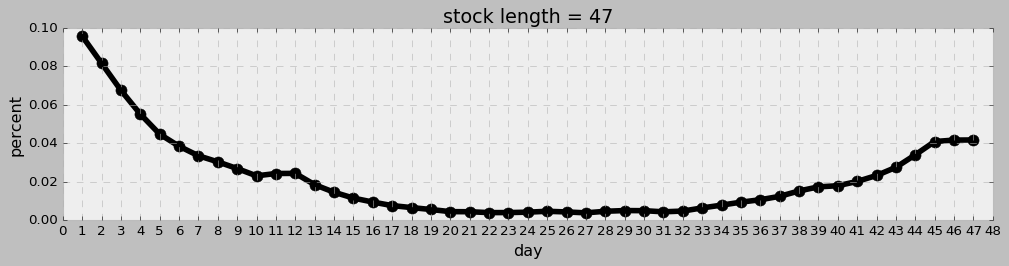

checking sum of percents: 1.0


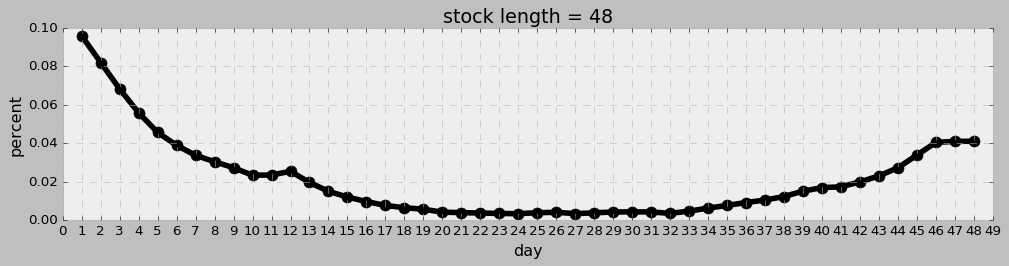

checking sum of percents: 1.0


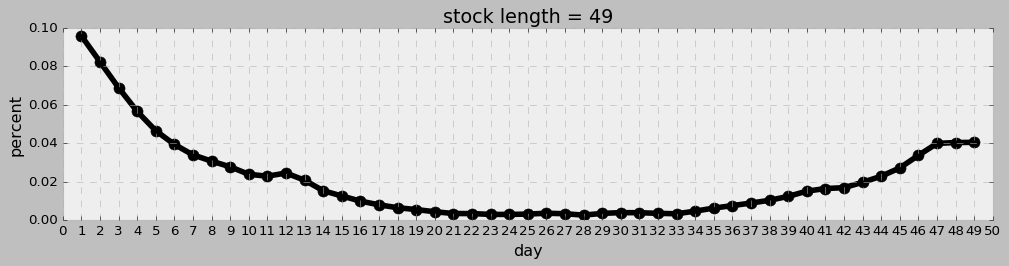

checking sum of percents: 1.0


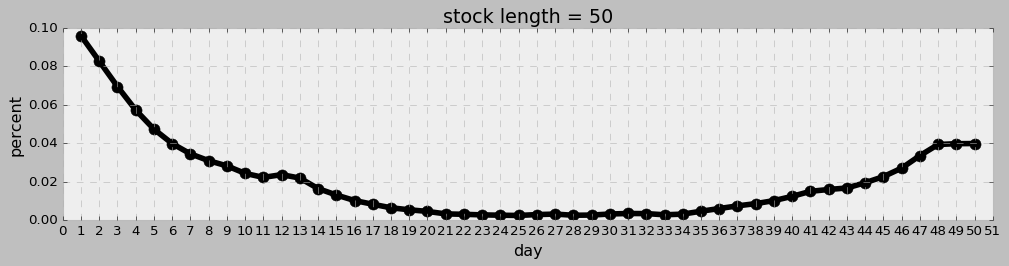

In [16]:
plot_predictions()